## Analyzing keio plate 1

This notebook runs the analysis pipeline for the preliminary data for Keio plate 1.

In [1]:
#Import packages
import numpy as np 
import os
import tifffile as tiff
from skimage.io import imread
from skimage.measure import label, regionprops
import scipy
import matplotlib.pyplot as plt
import cPickle as pickle
from SLIP_functions import analyze_well, analyze_plate, segment_SLIP, plot_slip_well, plot_slip_wells, plot_slip_wells_gmm, plot_slip_wells_lysis_posterior
from SLIP_functions import plot_slip_joint_plot, fit_kde, compute_p_values
from SLIP_functions import classify_infections, compute_p_lysis_posterior, compute_MOI_posterior
from keio_names import get_keio_names, pos_to_strain
import seaborn as sns
import pandas as pd
import pymc3 as pm

sns.set_context('notebook', font_scale = 1.1)
sns.set_style('white')
sns.set_style('ticks')

#Activate matplotlib inline
%matplotlib inline

#Define root directory path
root_direc = '/media/vanvalen/fe0ceb60-f921-4184-a484-b7de12c1eea6/keio_screen/08.03.2017/keio1_2/'
plate_number = 1

#Define directory path to infection data (all positions)
data_direc = os.path.join(root_direc, 'data')

#Define directory path to control data (all positions)
control_direc = os.path.join(root_direc, 'control')

#Define directory path to where you want to store neural net outputs. 
#mask directories must exist at run time!
mask_direc = os.path.join(root_direc, 'masks')
control_mask_direc = os.path.join(root_direc,'control_masks')

tifffile.py:156: UserWarning: failed to import the optional _tifffile C extension module.
Loading of some compressed images will be slow.
Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "failed to import the optional _tifffile C extension module.\n"
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5005)


In [2]:
#Define which wells were used
row_control = ['A']
col_control = [12]

row_data = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
col_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [3]:
#Load saved data
mean_FITC_name = os.path.join(root_direc, 'mean_FITC.pkl')
mean_cherry_name = os.path.join(root_direc, 'mean_cherry.pkl')
mean_FITC = pickle.load(open(mean_FITC_name, 'rb'))
mean_cherry = pickle.load(open(mean_cherry_name, 'rb'))

mean_FITC_control_name = os.path.join(root_direc, 'mean_FITC_control.pkl')
mean_cherry_control_name = os.path.join(root_direc, 'mean_cherry_control.pkl')
mean_FITC_control = pickle.load(open(mean_FITC_control_name, 'rb'))
mean_cherry_control = pickle.load(open(mean_cherry_control_name, 'rb'))

p_values_dict_name = os.path.join(root_direc, 'p_values_dict.pkl')
p_values_dict = pickle.load(open(p_values_dict_name, 'rb'))

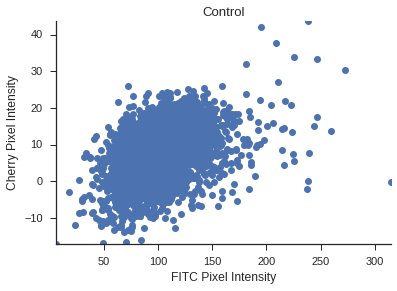

In [4]:
#Plot the data from the control plate
plot_slip_well(mean_FITC_control, mean_cherry_control, well = 'A12', title = 'Control')
sns.despine()

/home/vanvalen/.pyenv/versions/2.7.4/envs/DeepCell/lib/python2.7/site-packages/openpyxl/reader/worksheet.py:310: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


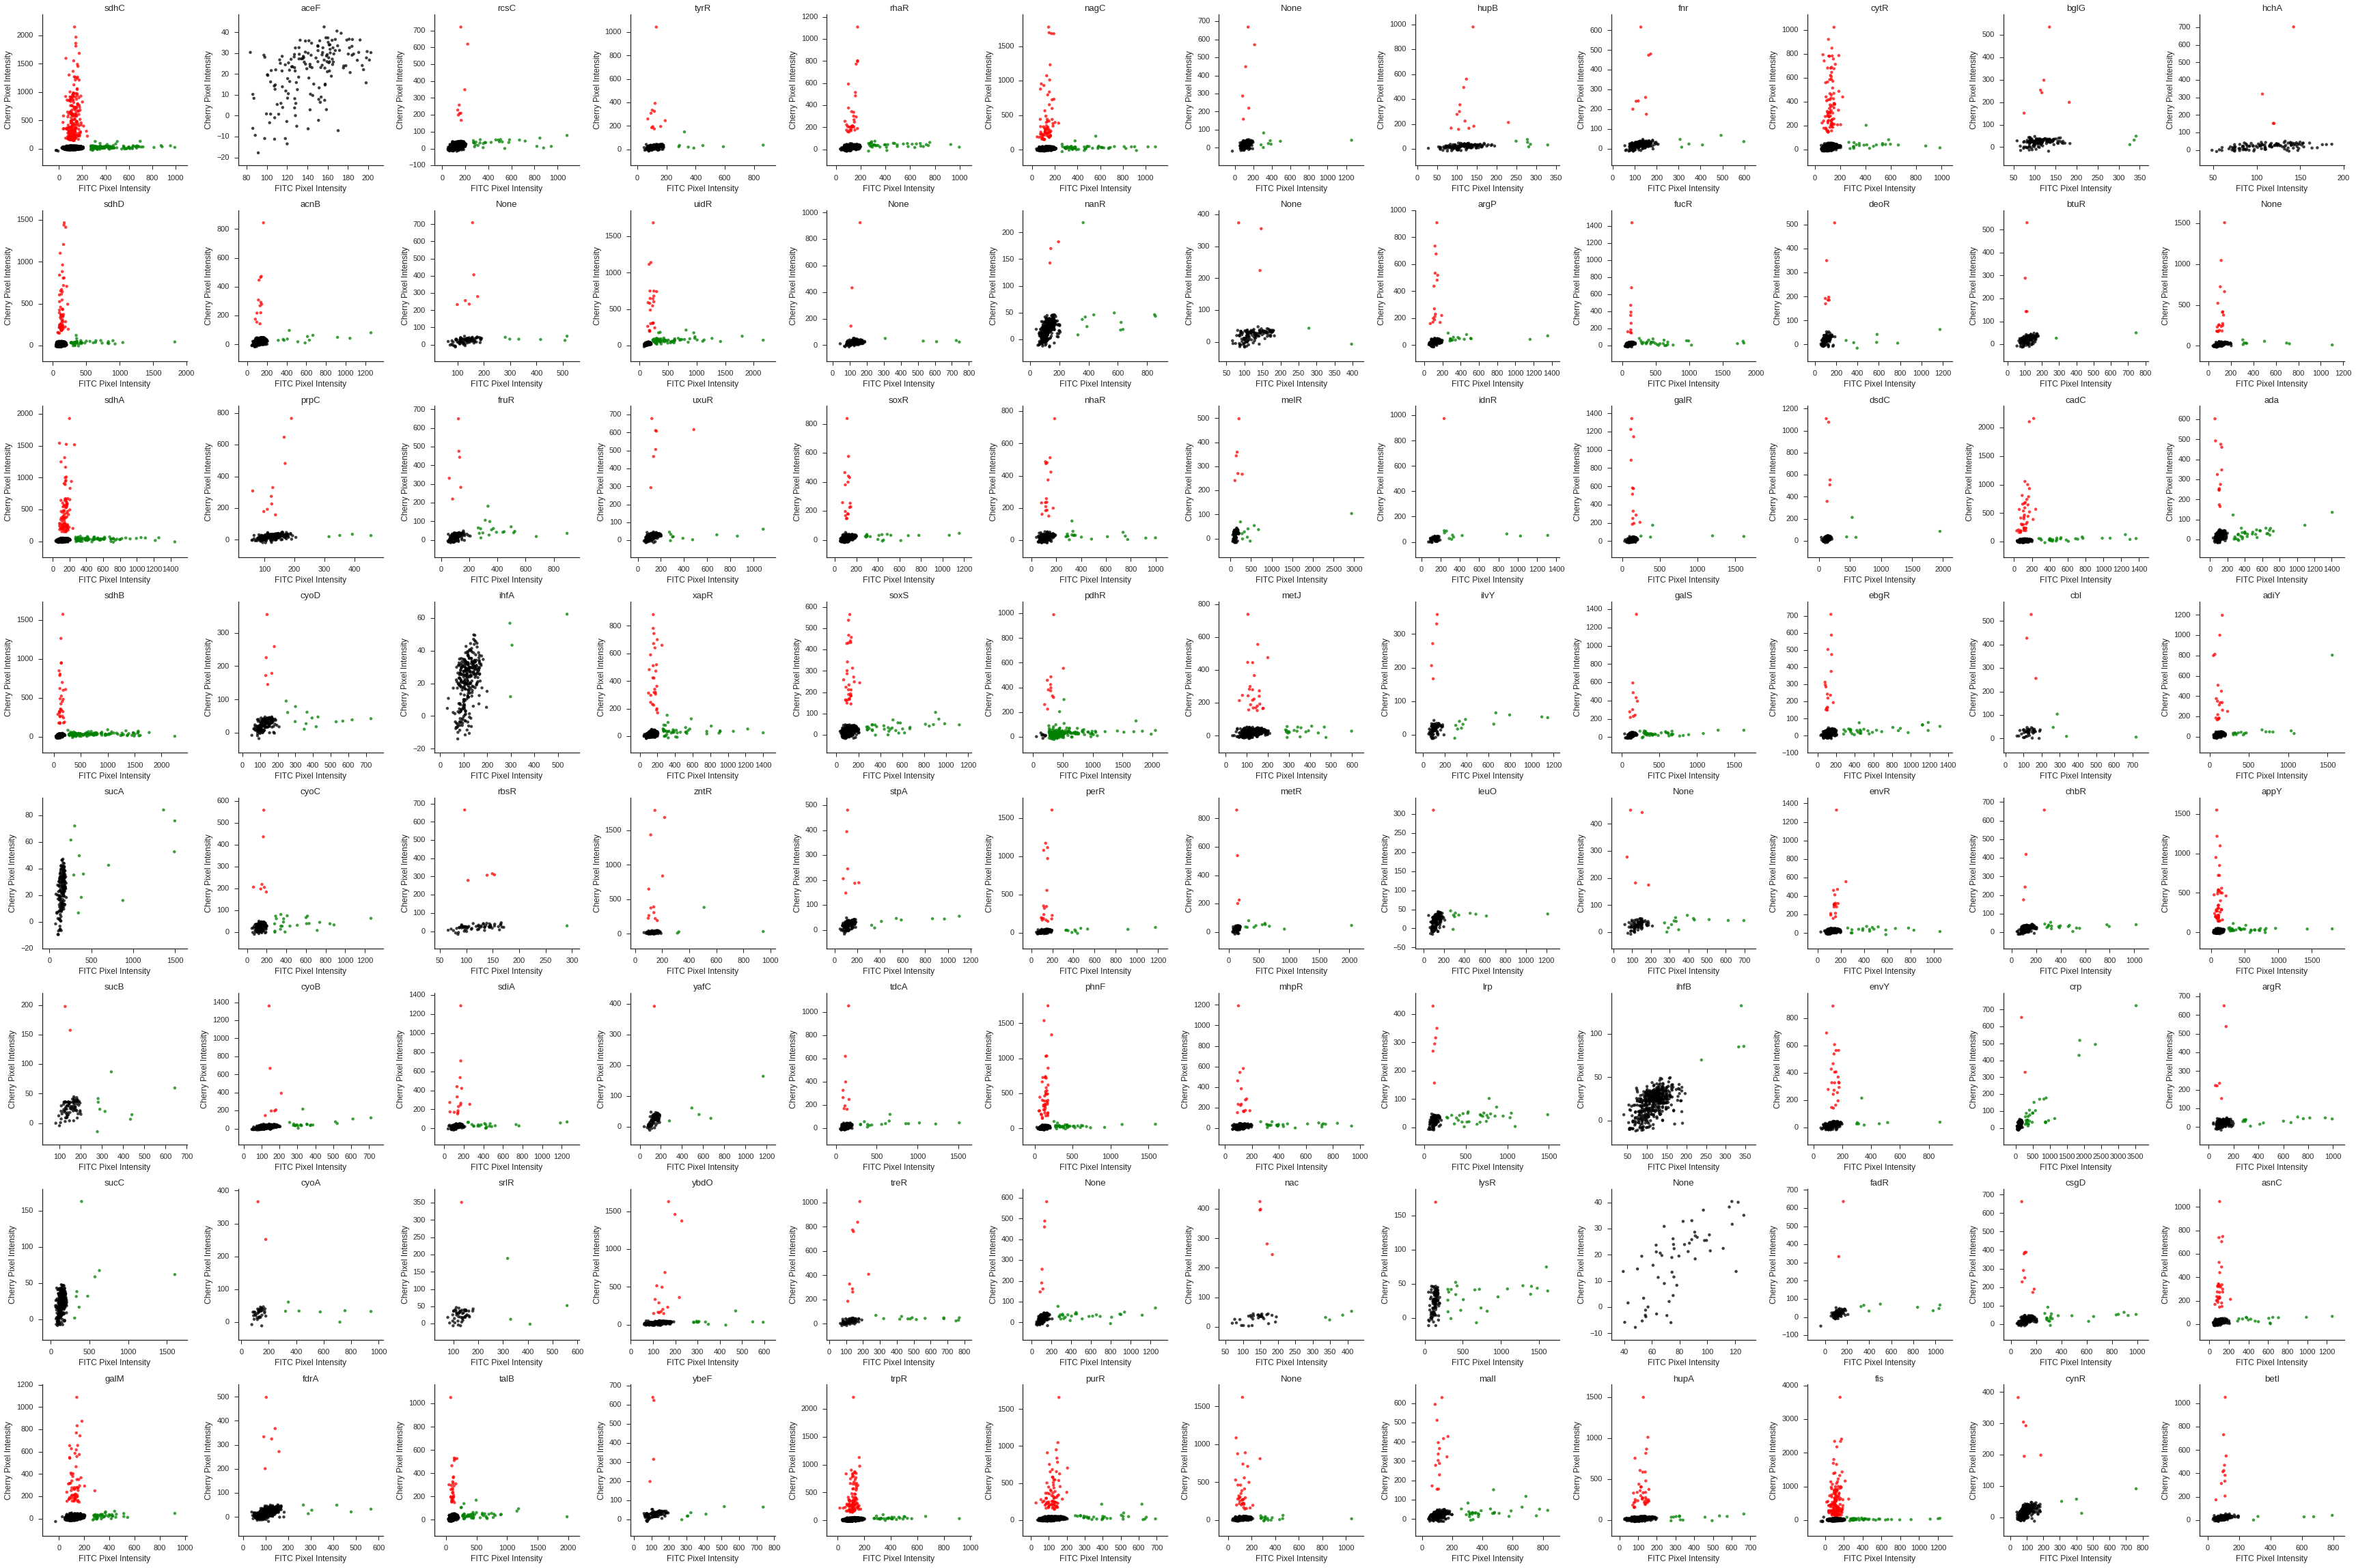

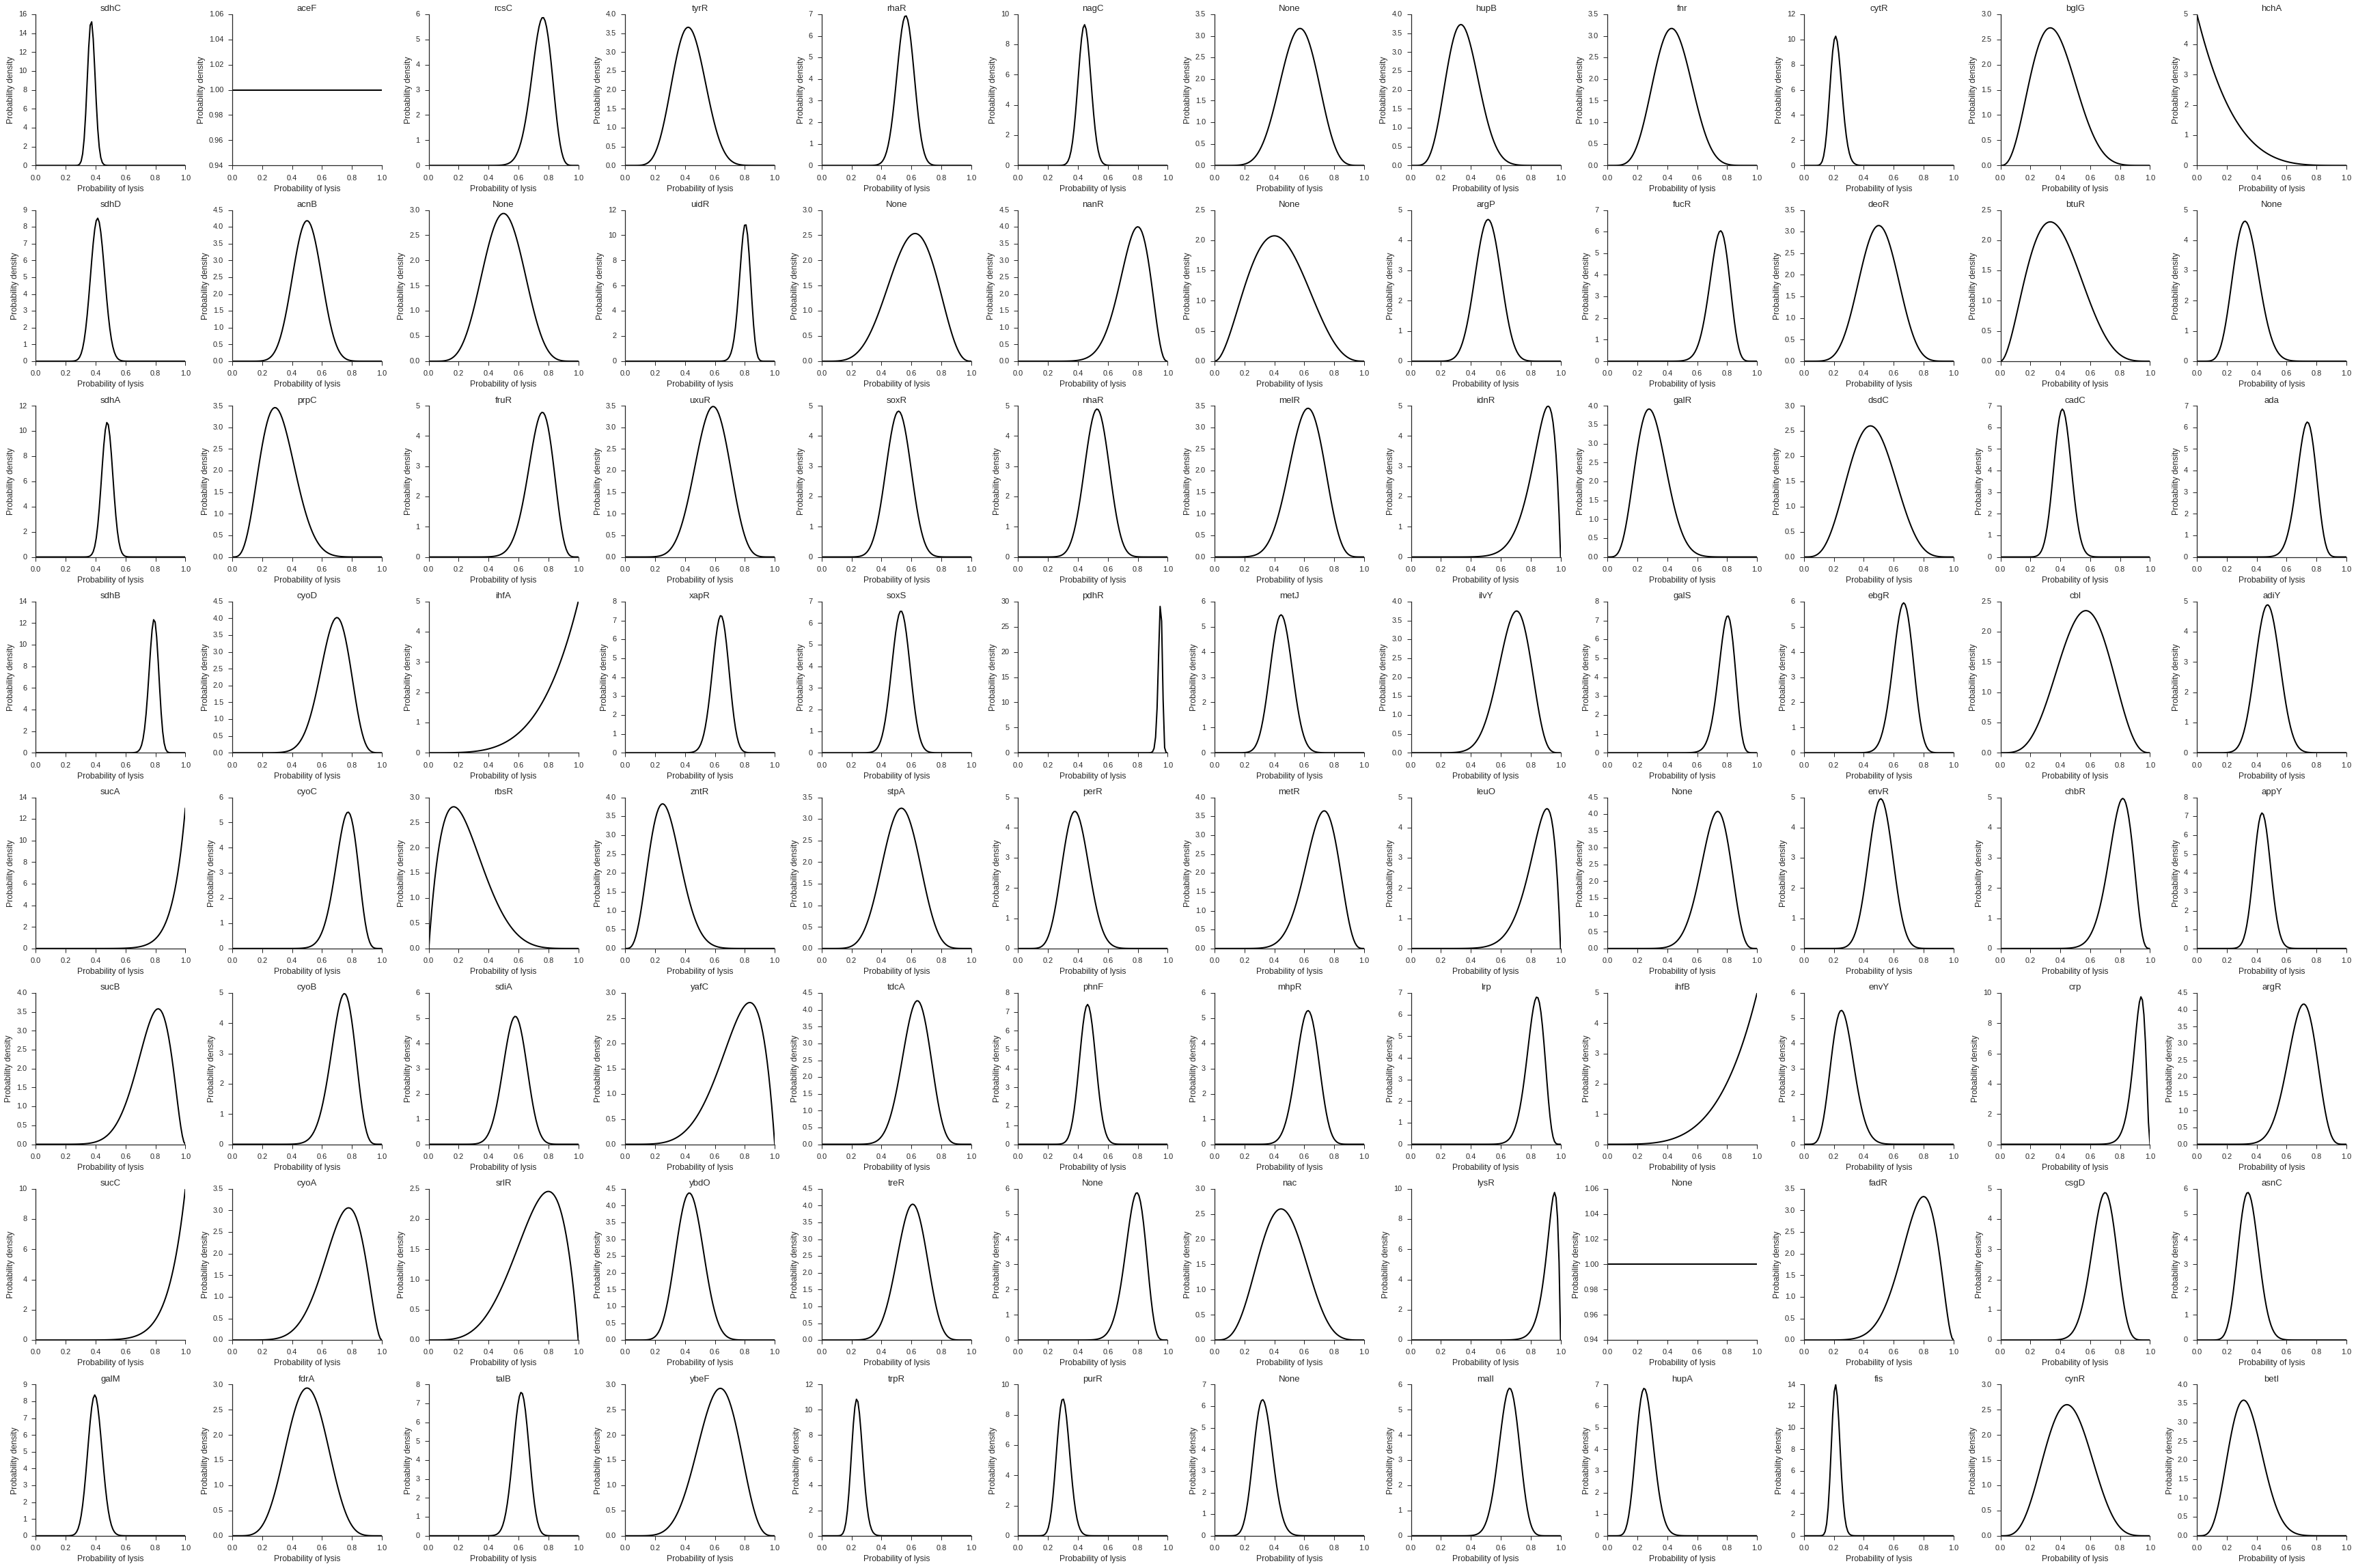

In [5]:
#Plot the scatter plot of intensities
wells = []
titles = []
keio_names_array = get_keio_names()

for row in row_data:
    for col in col_data:
        well = row + str(col)
        wells += [well]
        titles += [pos_to_strain(keio_names_array, 1, well)]

plot_slip_wells_gmm(mean_FITC, mean_cherry, wells = wells, titles = titles, plate_number = 1)
plot_slip_wells_lysis_posterior(mean_FITC, mean_cherry, wells = wells, titles = titles, plate_number = 1)

In [ ]:
#Print the number of cells in each well
for key in mean_FITC_control.keys():
    print key, len(mean_FITC_control[key])
    
for key in mean_FITC.keys():
    print key, len(mean_FITC[key])

In [16]:
# Fit a KDE estimator to the no infection control
kernel = fit_kde(mean_FITC_control, mean_cherry_control, 'A12')

In [17]:
#Compute the fraction infected in each well and plot
conc_list = []
fraction_infected_list = []
for well in p_values_dict.keys():
    p_value = p_values_dict[well]
    fraction_infected = np.float(np.where(p_value < 0.01)[0].shape[0])/np.float(p_value.shape[0])
    fraction_infected_list += [fraction_infected]
    
    print well, fraction_infected

G7 0.860465116279
G6 0.60594795539
G5 0.672131147541
G4 0.648501362398
G3 0.75
G2 0.785714285714
G1 0.715068493151
G9 0.366666666667
G8 0.773006134969
B4 0.930693069307
B5 0.633540372671
B6 0.576530612245
B7 0.616438356164
B1 0.644651162791
B2 0.678111587983
B3 0.678571428571
B8 0.712230215827
B9 0.652777777778
E9 0.761904761905
E8 0.588235294118
E5 0.651428571429
E4 0.748148148148
E7 0.77
E6 0.701357466063
E1 0.746606334842
E3 0.648648648649
E2 0.775862068966
H10 0.395057660626
H11 0.506142506143
H12 0.616935483871
F12 0.675373134328
F10 0.609561752988
F11 0.75
H8 0.690625
H9 0.54406779661
H2 0.560344827586
H3 0.66339869281
H1 0.44738628649
H6 0.606910039113
H7 0.649612403101
H4 0.741007194245
H5 0.572951365756
D10 0.569844789357
D11 0.80701754386
D12 0.625352112676
B12 0.632716049383
B10 0.6
B11 0.58273381295
C9 0.674121405751
C8 0.767441860465
C3 0.6375
C2 0.636690647482
C1 0.673816568047
C7 0.647058823529
C6 0.592476489028
C5 0.479915433404
C4 0.650485436893
G12 0.590818363273
G11 

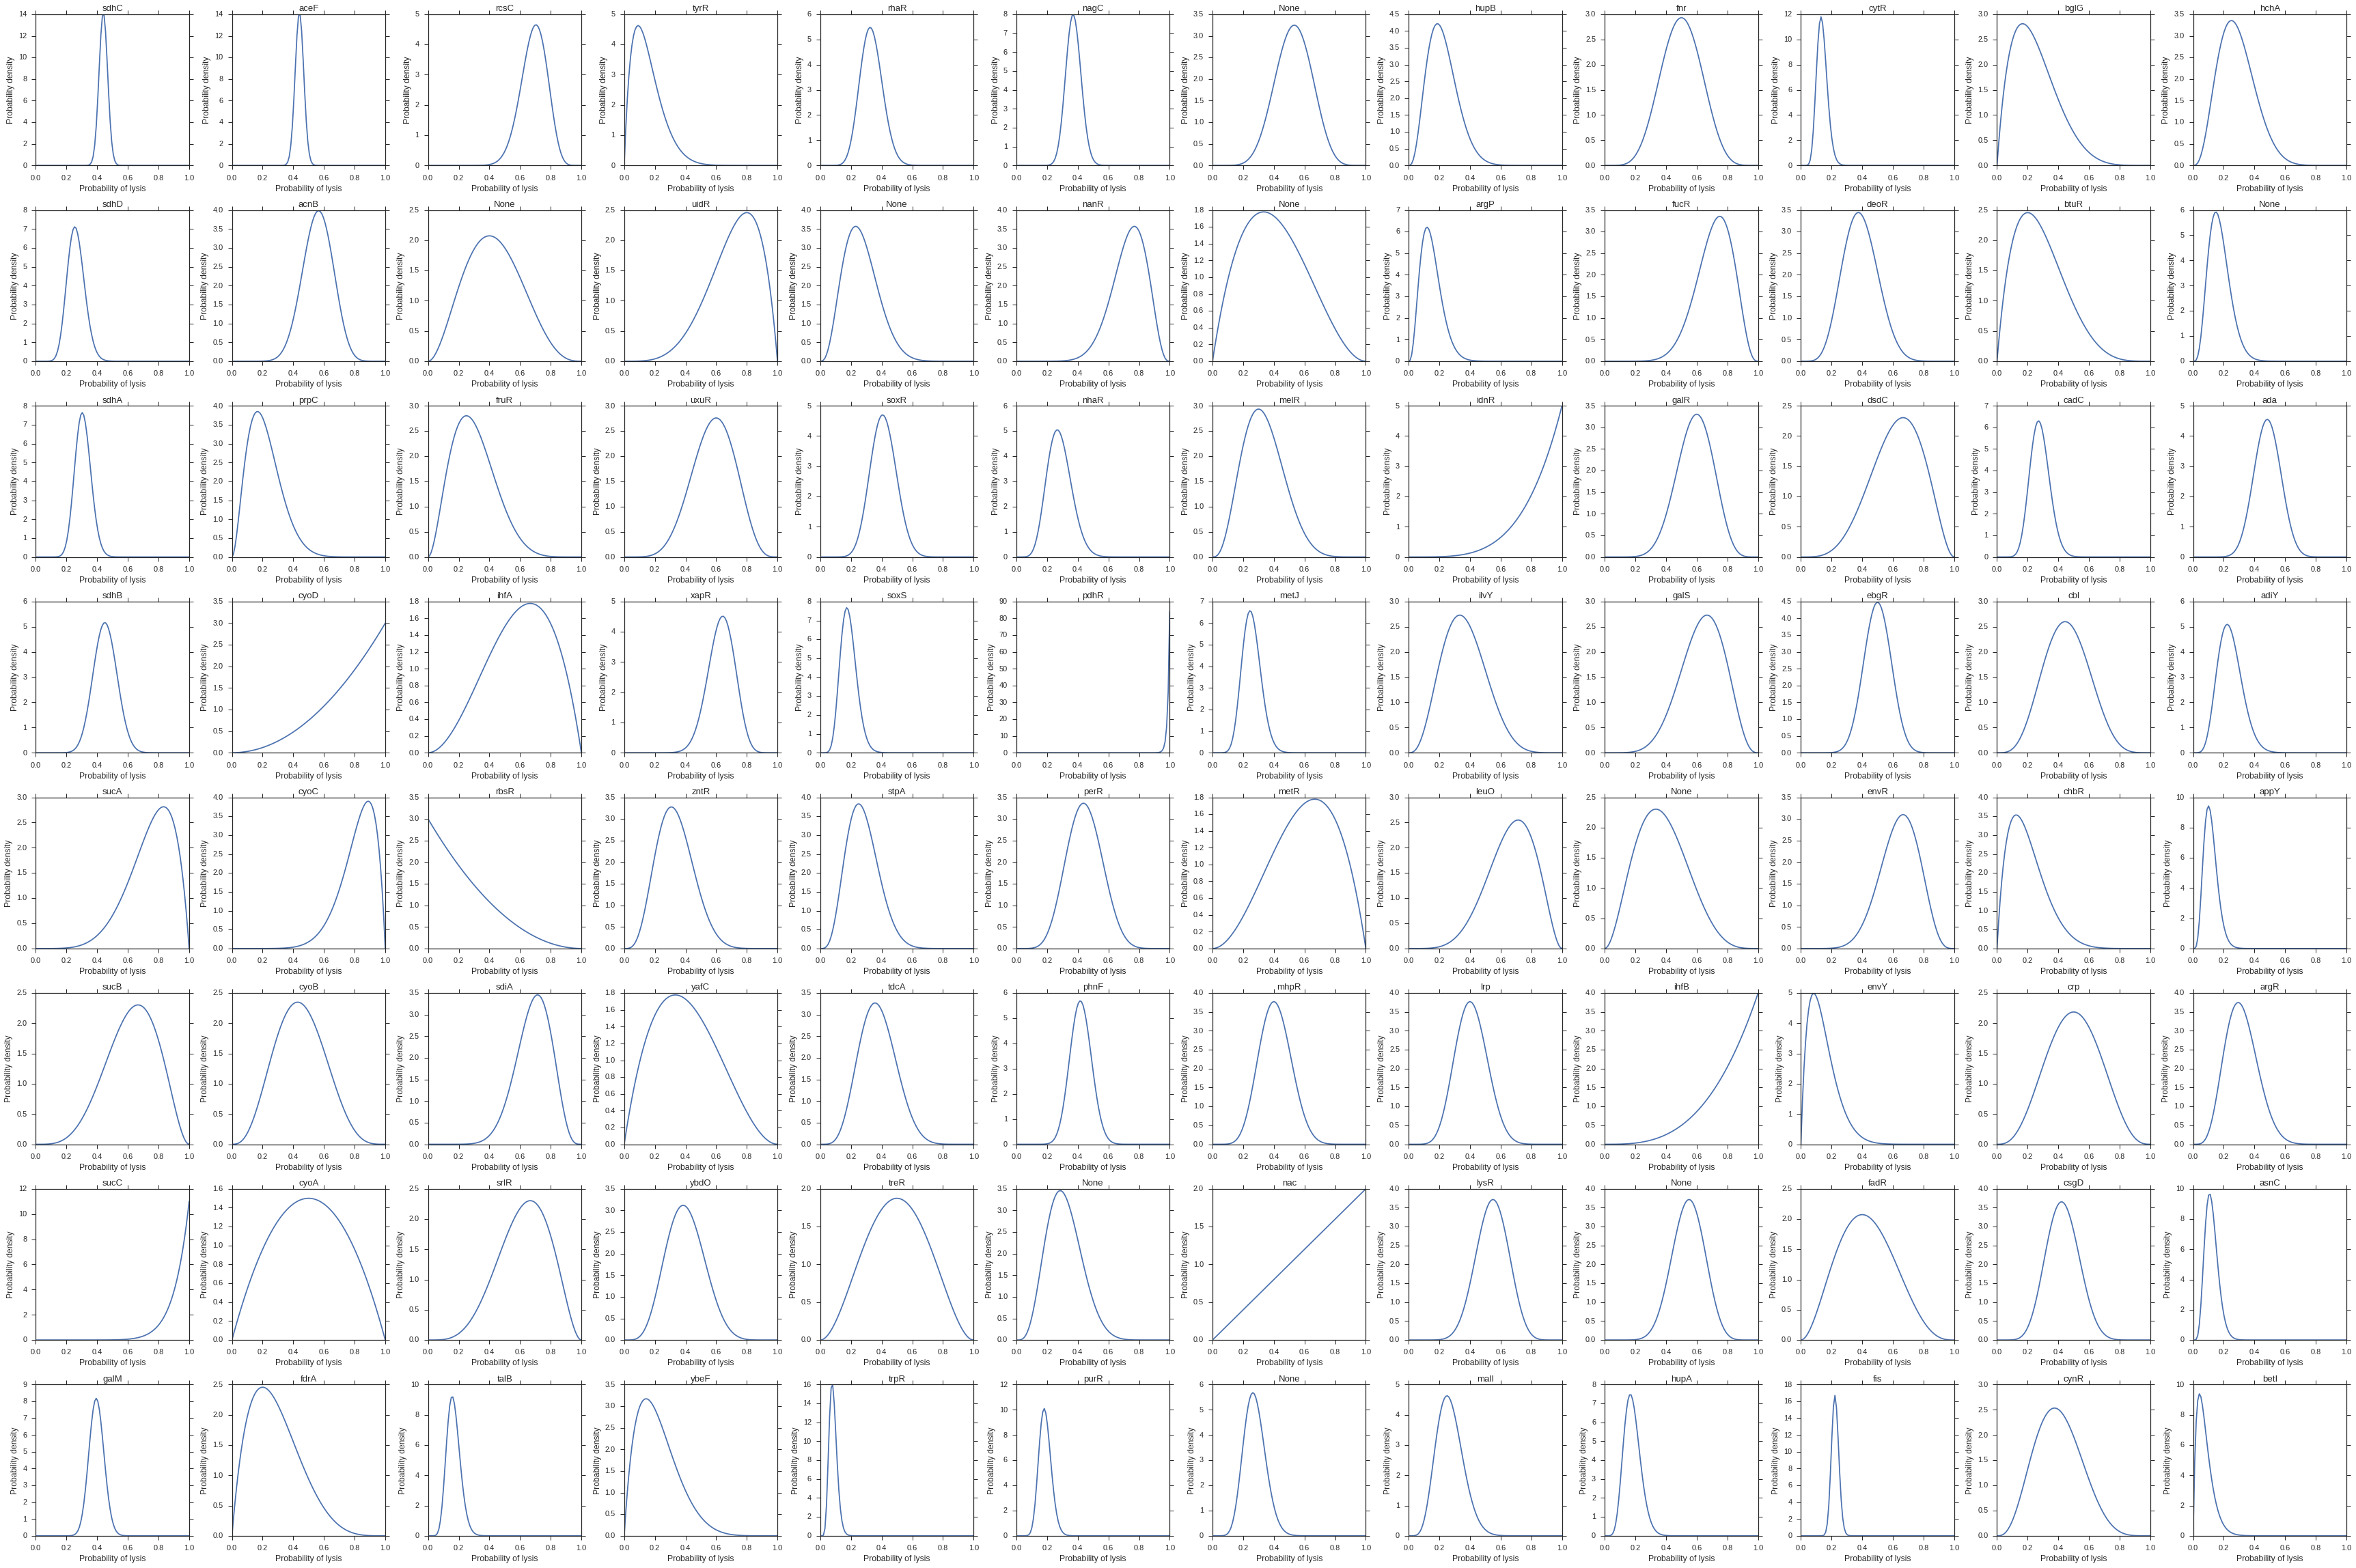

In [18]:
# Use the no phage control to construct a lysis/lysogeny classifier
fitc_control_array = np.array(mean_FITC_control['A12'])
cherry_control_array = np.array(mean_cherry_control['A12'])
kernel_fitc = scipy.stats.gaussian_kde(fitc_control_array)
kernel_cherry = scipy.stats.gaussian_kde(cherry_control_array)

def compute_p_lysis_posterior(N_lysis, N_lysogeny):
    x = np.linspace(0,1,100)
    posterior= scipy.stats.beta.pdf(x, 1+N_lysis, 1+N_lysogeny)
    return x, posterior

# d = classify_infections(kernel_fitc, kernel_cherry, p_values_dict, rows = row_data, cols = col_data)

kn = get_keio_names()
fig, axes = plt.subplots(8,12, figsize = (4*12, 4*8))

for row in row_data:
    for col in col_data:
        well = row + str(col)
        
        well_name = pos_to_strain(kn, plate = plate_number, pos = well)
        p_value = p_values_dict[well]
        infected_cells = np.where(p_value < 0.01)[0]
        fitc_list = np.array(mean_FITC[well])[infected_cells]
        cherry_list = np.array(mean_cherry[well])[infected_cells]

        p_fitc = []
        p_cherry = []
        for fitc, cherry in zip(fitc_list, cherry_list):
            p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
            p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

        # Remove double positives
        p_fitc_new = []
        p_cherry_new = []
        fitc_list_new = []
        cherry_list_new = []
        for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
            if (p_f < 0.85 and c > 50) or p_c < 0.85:
                p_fitc_new += [p_f]
                p_cherry_new += [p_c]
                fitc_list_new += [f]
                cherry_list_new += [c]

        p_fitc = p_fitc_new
        p_cherry = p_cherry_new
        fitc_list = fitc_list_new
        cherry_list = cherry_list_new

        d = {'FITC Probability': p_fitc, 'Cherry Probability': p_cherry}
        dataframe = pd.DataFrame(data = d)
#         grid = sns.lmplot('FITC Probability', 'Cherry Probability', dataframe, fit_reg = False)
#         ax = grid.axes[0][0]
#         ax.set_title(well_name)
#         ax.set_xlim([-0.05, 1.05])
#         ax.set_ylim([-0.05, 1.05])

        d = {'FITC Intensity': fitc_list, 'Cherry Intensity': cherry_list}
        dataframe = pd.DataFrame(data = d)
#         grid = sns.lmplot('FITC Intensity', 'Cherry Intensity', dataframe, fit_reg = False, scatter_kws = {'color': 'red'})
#         ax = grid.axes[0][0]
#         ax.set_title(well_name)

        counter = 0
        for p_f, p_c in zip(p_fitc, p_cherry):
            if p_f > p_c:
                counter += 1
                
        if len(p_fitc) > 0:
            #Uncomment to print p_lysis
            #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
            
            x, posterior = compute_p_lysis_posterior(counter, len(p_fitc) - counter)
            
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('Probability of lysis')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
        else:    
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('Probability of lysis')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
            
plt.tight_layout()
    

sucC 10 0


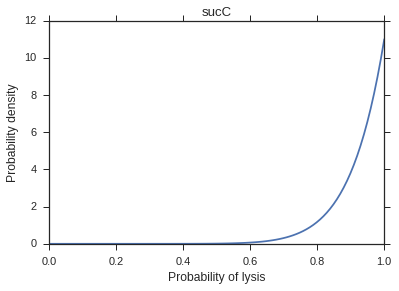

In [23]:
well = "G1"
        
well_name = pos_to_strain(kn, plate = plate_number, pos = well)
p_value = p_values_dict[well]
infected_cells = np.where(p_value < 0.01)[0]
fitc_list = np.array(mean_FITC[well])[infected_cells]
cherry_list = np.array(mean_cherry[well])[infected_cells]

p_fitc = []
p_cherry = []
for fitc, cherry in zip(fitc_list, cherry_list):
    p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
    p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

# Remove double positives
p_fitc_new = []
p_cherry_new = []
fitc_list_new = []
cherry_list_new = []
for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
    if (p_f < 0.85 and c > 50) or p_c < 0.85:
        p_fitc_new += [p_f]
        p_cherry_new += [p_c]
        fitc_list_new += [f]
        cherry_list_new += [c]

p_fitc = p_fitc_new
p_cherry = p_cherry_new
fitc_list = fitc_list_new
cherry_list = cherry_list_new

counter = 0
for p_f, p_c in zip(p_fitc, p_cherry):
    if p_f > p_c:
        counter += 1
                
if len(p_fitc) > 0:
    #Uncomment to print p_lysis
    #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
    print well_name, counter, len(p_fitc)-counter
    x, posterior = compute_p_lysis_posterior(counter, len(p_fitc) - counter)

    alphabet = ['A','B','C','D','E','F','G','H']
    chars = list(well)
    row_temp = alphabet.index(chars[0])
    if len(chars) == 2:
        col_temp = int(chars[1])-1
    if len(chars) == 3:
        col_temp = int(chars[1] + chars[2])-1
    fig = plt.figure()
    axes = plt.gca()
    axes.plot(x, posterior)
    axes.set_xlim([0, 1])
    axes.set_xlabel('Probability of lysis')
    axes.set_ylabel('Probability density')
    axes.set_title(well_name)

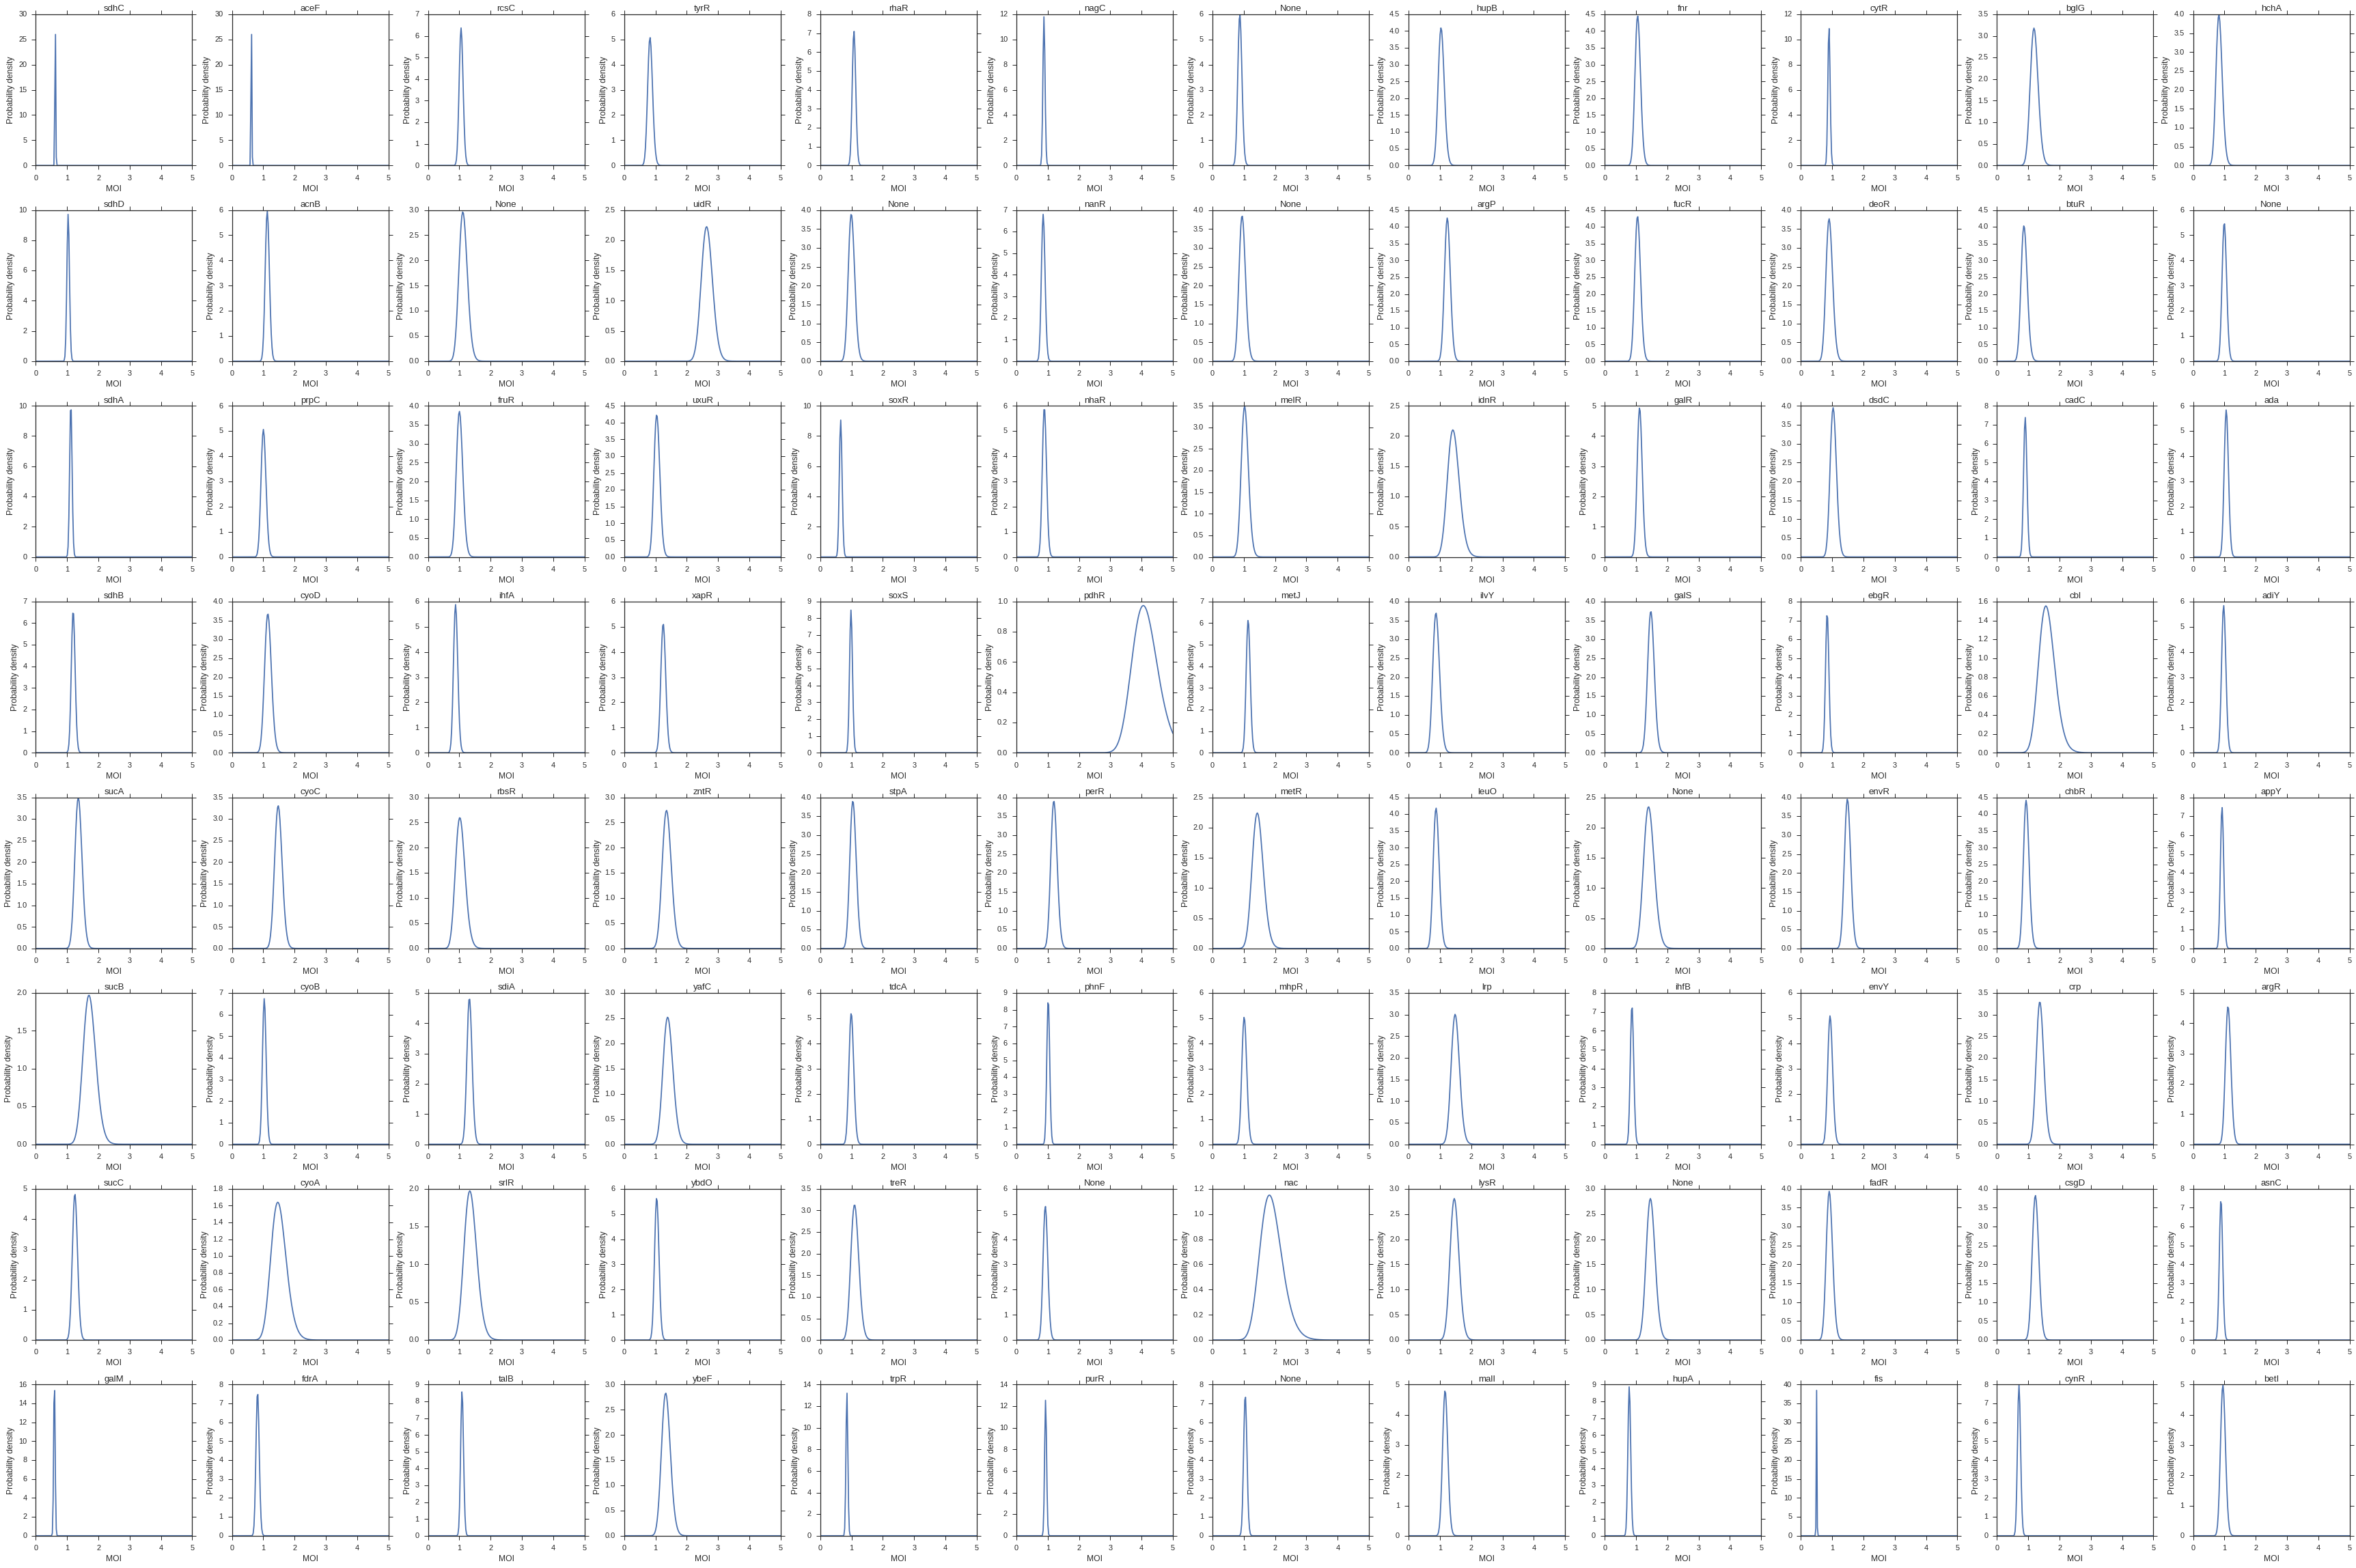

In [22]:
fig, axes = plt.subplots(8,12, figsize = (4*12, 4*8))

def compute_inverse_MOI_posterior(N_infected, N_cells):
    x = np.linspace(0,5,200)
    gamma = np.float(N_cells)*np.log(1-1/np.float(N_cells))
    posterior = np.abs(gamma*np.exp(gamma*x))*scipy.stats.beta.pdf(np.exp(gamma*x), 1+N_cells-N_infected, 1+N_infected)

    return x, posterior

kn = get_keio_names()

for row in row_data:
    for col in col_data:
        well = row + str(col)
        
        well_name = pos_to_strain(kn, plate = plate_number, pos = well)
        p_value = p_values_dict[well]
        infected_cells = np.where(p_value < 0.01)[0]
        fitc_list = np.array(mean_FITC[well])[infected_cells]
        cherry_list = np.array(mean_cherry[well])[infected_cells]

        p_fitc = []
        p_cherry = []
        for fitc, cherry in zip(fitc_list, cherry_list):
            p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
            p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

        # Remove double positives
        p_fitc_new = []
        p_cherry_new = []
        fitc_list_new = []
        cherry_list_new = []
        for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
            if (p_f < 0.85 and c > 50) or p_c < 0.85:
                p_fitc_new += [p_f]
                p_cherry_new += [p_c]
                fitc_list_new += [f]
                cherry_list_new += [c]

        p_fitc = p_fitc_new
        p_cherry = p_cherry_new
        fitc_list = fitc_list_new
        cherry_list = cherry_list_new

        counter = 0
        for p_f, p_c in zip(p_fitc, p_cherry):
            if p_f > p_c:
                counter += 1
                
        if len(p_fitc) > 0:
            #Uncomment to print p_lysis
            #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
            x, posterior = compute_inverse_MOI_posterior(infected_cells.shape[0], p_value.shape[0])
            
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 5])
            axes[row_temp, col_temp].set_xlabel('MOI')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
        else:    
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 5])
            axes[row_temp, col_temp].set_xlabel('MOI')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
            
plt.tight_layout()